# Reinforcement learning

## Implementation with a neural network

Idea: Train a neural network to calculate, for a given state $s$, the return of the state action value functions for the actions possible in that state, so we can choose the one with largest $Q(s, a)$. In other words, train a neural network that given s and a returns $y \approx Q(a,a)$. Or, in less words, train the neural network to learn the Bellman equation.

To do so, we can create a large set of tuples

$$(s^{(1)}, a^{(1)}, R(s^{(1)}), s'^{(1)}) \\ (s^{(2)}, a^{(2)}, R(s^{(2)}), s'^{(2)}) \\ \dots$$

And then, the training examples for the neural network will be:

* For the inputs $x$, each of the tuples 
$$(s^{(1)}, a^{(1)}), (s^{(2)}, a^{(2)}), \dots$$
* For the target values y, the corresponding 
$$Q(s^{(1)},a^{(1)}), Q(s^{(2)},a^{(2)}), \dots$$

calculated with the Bellman equation, for example

$$Q(s^{(1)}, a^{(1)}) = R(s^{(1)}) + \gamma \max_{a'} Q(s'^{(1)}, a')$$

Note that the target values $y$ depend only on the last two elements of the tuples $(s^{(i)}, a^{(i)}, R(s^{(i)}), s'^{(i)})$

At the begining, we don't know the $Q(s, a)$ function, but it can be initialized randomly. In every step, it will get better.

Learning algorithm (sometimes call the **Deep-Q network**)

<pre>
    Initialize Q_nn neural network randomly as guess of Q(s, a)
    Repeat {
        Take actions to generate tuples (s, a, R(s), s')
        Store the 10,000 more recent examples of these tuples (replay buffer)
        Train neural network:
            Create training set of 10,000 examples x, y using
                x = (s, a) and y = R(s) + &gamma; max<sub>a'</sub> Q_nn(s', a')
            Train Q<sub>new</sub> such that Q<sub>new</sub>(s, a) &asymp; y
        Set Q_nn = Q<sub>new</sub>
    }
</pre>

One possible architecture of the neural network is (from course example for lunar lander, with 8 parameters for the state, and 4 possible actions, one hot encoded):

```Pyhton
tf.keras.models.Sequential ([
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
]) 
```

An improved architecture uses (for this case) four units in the output layer, to compute at the same time the $Q(s, a)$ function for all the possible actions in one state. The input, in this case, is the 8 parameters that represent the state.

```Pyhton
tf.keras.models.Sequential ([
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4)
]) 
```

> Note: With this network configuration, the standard way to calculate the loss won't work, as the Bellman equation uses the four outputs. See how it is done in the implementation example bellow.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import random
import numpy as np
import pandas as pd

import tensorflow as tf
import keras

from collections import deque

from tqdm.notebook import trange

import gymnasium as gym
from gymnasium.utils.save_video import save_video


In [2]:
STATE_DIM = 8                   # Dimension of the state array
N_ACTIONS = 4                   # Number of possible actions

N_EPISODES = 1_000              # Number of episodes to run for training 
MEMORY_BUFFER = 100_000         # Experience memory size  
BATCH_SIZE = 64                 # Batch size for neural network training 
UPDATE_STEP = 4                 # Number of steps to update target model

TAU =  0.05                    # Parameter for the soft update of the weights 
GAMMA = 0.995                    # Discount factor for the calculation of the return 

In [3]:
EPSILON_INTERVALS = [(200, .9), (400, .5), (600, .3), (1000, .1)]

def get_epsilon(episode):

    for l, e in EPSILON_INTERVALS:
        if episode <= l:
            return e
    return 0

In [4]:

def q_model():

    return keras.models.Sequential ([
            keras.layers.Input(shape=(STATE_DIM,)),
            keras.layers.Dense(64, activation='relu'),
            keras.layers.Dense(64, activation='relu'),
            keras.layers.Dense(4)
        ]) 

In [5]:
# See https://gymnasium.farama.org/environments/box2d/lunar_lander/

# rng for the environment and to reshuffle samples
rng = np.random.default_rng(seed=34)

env = gym.make('LunarLander-v2', render_mode=None)
env.np_random = rng

# Actions: 0: do nothing, 1: fire left orientation engine, 2: fire main engine, 3: fire right orientation engine
# State: [x, y, vx, vy, theta, omega, bool, bool ] The booleans represent if the legs are in contact with the ground

In [6]:

# Taken from: https://keras.io/examples/keras_recipes/reproducibility_recipes/
keras.utils.set_random_seed(812)
tf.config.experimental.enable_op_determinism()

In [7]:
# Model used to select actions. Gets updated every batch
q_function = q_model()

# Model used to calculate the rewards for the future predictions that are used
# in the Bellman equation used as target for the updates of q_function. It is a different
# one for stability. Gets updated every UPDATE_STEP
q_function_target = q_model()
q_function_target.set_weights(q_function.get_weights())

loss_function = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam()

In [8]:
def get_samples(memory, sample_size):

  samples = random.sample(memory, sample_size)
  
  states, actions, states_next, rewards, terminated, truncated = zip(*samples)

  states = tf.convert_to_tensor(states, dtype='float32')
  actions = np.array(actions, dtype='int32')
  states_next = tf.convert_to_tensor(states_next, dtype='float32')
  rewards = np.array(rewards, dtype='float32')
  terminated = np.array(terminated, dtype='float32')

  return states, actions, states_next, rewards, terminated

In [9]:
# Train step

@tf.function
def train_step(samples, q_function, q_function_target):

  states, actions, states_next, rewards, terminated = samples

  # Use q_function_target to calculate Q(state_prime, action) used in Bellman equation
  max_qsa = tf.math.reduce_max(q_function_target(states_next, training=False), axis=1)

  # Bellman equation
  # For terminated states, q_value is just the reward
  qvalues_target = (rewards + (1 - terminated) * GAMMA * max_qsa)

  # Calculate mask so loss is calculated only on the action taken
  mask = tf.one_hot(actions, N_ACTIONS) 

  with tf.GradientTape() as tape:

    # Run model
    qvalues_predictions = tf.reduce_max(
      tf.multiply(q_function(states, training=True), mask), axis=1)

    # Calculate loss
    loss = loss_function(qvalues_target, qvalues_predictions)

  # Back propagation
  grads = tape.gradient(loss, q_function.trainable_variables)
  optimizer.apply_gradients(zip(grads, q_function.trainable_variables))

  return loss


In [10]:

memory = deque(maxlen=MEMORY_BUFFER) 
loss_hist = []
reward_hist = []
duration_hist = []
step = 0
episode_reward = 0      # To accumulate the rewards of the episode
episode_duration = 0    # To keep a step count for the episode


for episode in trange(N_EPISODES, desc="Episode"):

    state, _ = env.reset()
    episode_reward = 0
    episode_duration = 0
    terminated = False
    truncated = False

    epsilon = get_epsilon(episode)

    while not (terminated or truncated):
        # take action using e-greedy selection
        if rng.choice([True, False], p=[epsilon, 1 - epsilon]): 
            #action = env.action_space.sample()
            action = rng.choice(N_ACTIONS)
        else:
            # Use Q function to select next action
            state_tensor = tf.convert_to_tensor(state, dtype='float32')
            state_tensor = tf.expand_dims(state_tensor, 0)
            qvalue_predictions = q_function(state_tensor, training=False)

            action = np.argmax(qvalue_predictions[0])

        state_next, reward, terminated, truncated, _ = env.step(action)

        memory.append((state, action, state_next, reward, terminated, truncated))

        update = (step + 1 >= BATCH_SIZE) and not ((step + 1) % UPDATE_STEP)
        if update:
            #
            # Update q-function
            #

            samples = get_samples(memory, BATCH_SIZE)

            # Train network
            loss = train_step(samples, q_function, q_function_target)
            
            loss_hist.append(loss)

            # Update target model
            new_weights = []
            for new_w, old_w in zip(q_function.get_weights(), q_function_target.get_weights()):
                new_weights.append(TAU * new_w + (1 - TAU) * old_w)

            q_function_target.set_weights(new_weights)

        step += 1
        episode_duration += 1
        episode_reward += reward
        if terminated or truncated:
            # Experiment ended, reset the environment
            reward_hist.append(episode_reward)
            duration_hist.append(episode_duration)
        else:
            state = state_next

Episode:   0%|          | 0/1000 [00:00<?, ?it/s]

<Axes: >

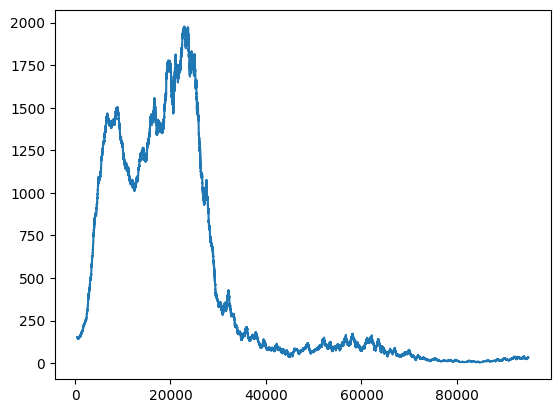

In [11]:
loss_df = pd.Series(loss_hist)
loss_df.rolling(window=500).mean().plot()

array([[<Axes: >, <Axes: >]], dtype=object)

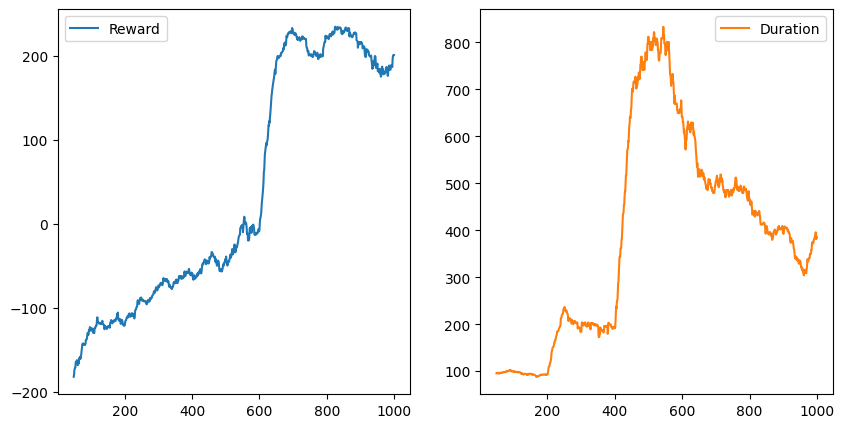

In [12]:

df_episodes = pd.DataFrame({
    "Reward": reward_hist,
    "Duration": duration_hist
    })
df_episodes.rolling(window=50).mean().plot(subplots=True, layout=(1,2), figsize=(10, 5))

In [13]:
keras.saving.save_model(q_function, "q_function.keras")

In [14]:

# Evaluation
demo_env = gym.make('LunarLander-v2', render_mode=None)
count = 0
landed = 0

for i in range(100):
    state, _ = demo_env.reset()
    
    cumm_reward = 0
    
    while True:
        state_tensor = tf.convert_to_tensor(state, dtype='float32')
        state_tensor = tf.expand_dims(state_tensor, 0)
        
        state_predictions = q_function(state_tensor, training=False)
        
        # take action using e-greedy selection    
        action = np.argmax(state_predictions[0])
        
        state, reward, terminated, truncated, _ = demo_env.step(action)

        cumm_reward += reward

        if terminated or truncated:
            if cumm_reward >= 200:
                count += 1
            if reward == 100:
                landed += 1
            break
    
demo_env.close()

print (f"Successful {count}/100")
print (f"Landed {landed}/100")

Successful 93/100
Landed 94/100


In [15]:

demo_env = gym.make('LunarLander-v2', render_mode='rgb_array_list')
episodes_rewards = []

for i in range(10):
    state, _ = demo_env.reset()
    
    this_reward = []
    
    while True:
        state_tensor = tf.convert_to_tensor(state, dtype='float32')
        state_tensor = tf.expand_dims(state_tensor, 0)
        
        state_predictions = q_function(state_tensor, training=False)
        
        # take action using e-greedy selection
        
        action = np.argmax(state_predictions[0])
        
        state, reward, terminated, truncated, _ = demo_env.step(action)
                
        this_reward.append(reward)

        if terminated or truncated:
            save_video(
                demo_env.render(),
                "videos",
                episode_trigger=(lambda a: True),
                fps=demo_env.metadata["render_fps"], 
                episode_index=i
            )

            episodes_rewards.append(this_reward)
            break
    
df_rewards = pd.DataFrame(episodes_rewards).transpose()
demo_env.close()

Moviepy - Building video /home/damian/sandbox/atari/videos/rl-video-episode-0.mp4.
Moviepy - Writing video /home/damian/sandbox/atari/videos/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/damian/sandbox/atari/videos/rl-video-episode-0.mp4
Moviepy - Building video /home/damian/sandbox/atari/videos/rl-video-episode-1.mp4.
Moviepy - Writing video /home/damian/sandbox/atari/videos/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /home/damian/sandbox/atari/videos/rl-video-episode-1.mp4
Moviepy - Building video /home/damian/sandbox/atari/videos/rl-video-episode-2.mp4.
Moviepy - Writing video /home/damian/sandbox/atari/videos/rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /home/damian/sandbox/atari/videos/rl-video-episode-2.mp4
Moviepy - Building video /home/damian/sandbox/atari/videos/rl-video-episode-3.mp4.
Moviepy - Writing video /home/damian/sandbox/atari/videos/rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready /home/damian/sandbox/atari/videos/rl-video-episode-3.mp4
Moviepy - Building video /home/damian/sandbox/atari/videos/rl-video-episode-4.mp4.
Moviepy - Writing video /home/damian/sandbox/atari/videos/rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready /home/damian/sandbox/atari/videos/rl-video-episode-4.mp4
Moviepy - Building video /home/damian/sandbox/atari/videos/rl-video-episode-5.mp4.
Moviepy - Writing video /home/damian/sandbox/atari/videos/rl-video-episode-5.mp4



Moviepy - Done !
Moviepy - video ready /home/damian/sandbox/atari/videos/rl-video-episode-5.mp4
Moviepy - Building video /home/damian/sandbox/atari/videos/rl-video-episode-6.mp4.
Moviepy - Writing video /home/damian/sandbox/atari/videos/rl-video-episode-6.mp4



Moviepy - Done !
Moviepy - video ready /home/damian/sandbox/atari/videos/rl-video-episode-6.mp4
Moviepy - Building video /home/damian/sandbox/atari/videos/rl-video-episode-7.mp4.
Moviepy - Writing video /home/damian/sandbox/atari/videos/rl-video-episode-7.mp4



Moviepy - Done !
Moviepy - video ready /home/damian/sandbox/atari/videos/rl-video-episode-7.mp4
Moviepy - Building video /home/damian/sandbox/atari/videos/rl-video-episode-8.mp4.
Moviepy - Writing video /home/damian/sandbox/atari/videos/rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready /home/damian/sandbox/atari/videos/rl-video-episode-8.mp4
Moviepy - Building video /home/damian/sandbox/atari/videos/rl-video-episode-9.mp4.
Moviepy - Writing video /home/damian/sandbox/atari/videos/rl-video-episode-9.mp4



Moviepy - Done !
Moviepy - video ready /home/damian/sandbox/atari/videos/rl-video-episode-9.mp4


array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >]], dtype=object)

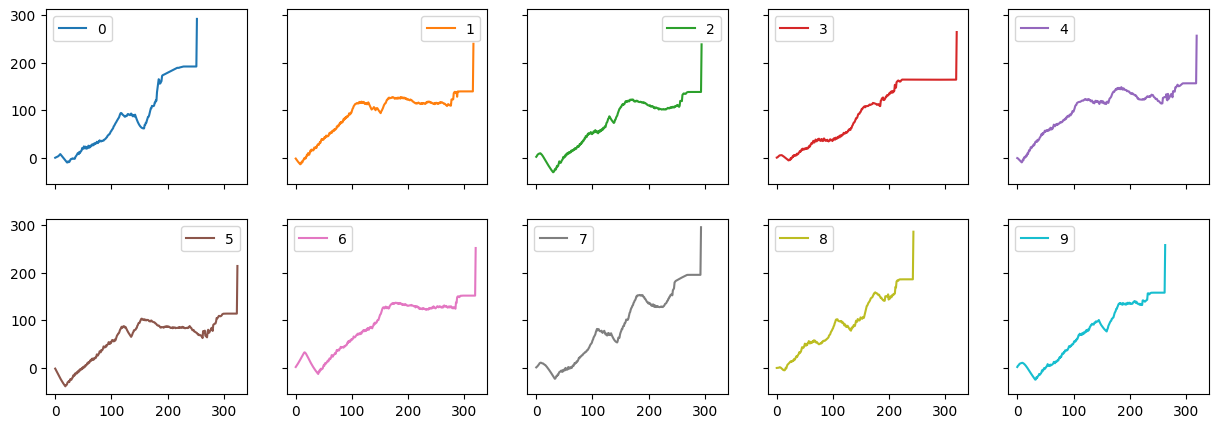

In [16]:

df_rewards.cumsum().plot(subplots=True, layout=(2,5), figsize=(15,5), sharey=True)